In [1]:
from astropy import units as u
from astropy import constants as c

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import exoplanet as xo
import theano.tensor as tt
import theano.tensor.extra_ops as ttx

import pandas as pd

import pymc3 as pm
%load_ext autoreload
%autoreload 2

In [2]:
dat=np.genfromtxt("k1255_lc.dat")

n_pnts=15000

#Taking a snippet of KIC1255 data for the model:
t=dat[:n_pnts,0]
flux= dat[:n_pnts,1]-np.nanmedian(dat[:n_pnts,1])
flux_err= dat[:n_pnts,2]
cadence=np.nanmedian(np.diff(t))

In [3]:
#Orbital params from BLS/candidate - we can fix these here as they should be good enough
t_0=566.824+0.5
P=0.6535538

In [70]:
# initial parameters
use_gp=True
init_planet_mass=0.025 #Roughly 25% Mars mass - should be undetectably small yet big enough to have a big hill sphere.
n_steps=35

#Counting number of transits to model, and assigning time to each nearby transit:
phase        = (t-t_0)/P
rounded_phase= np.round(phase)
trns_numbers = np.unique(rounded_phase)
phase_index  = np.vstack([[rounded_phase==n_tr] for n_tr in trns_numbers])

#Stellar params from e.g. TIC:
Rs=1.0#Rs=pm.Normal('Rs',mu=1.0,sd=0.1)
Ms=0.76#Ms=pm.Normal('Ms',mu=1.0,sd=0.15)
Teff=np.array([4677,100,100])
logg=np.array([4.63,0.25,0.25])

In [66]:
n_steps=23
phase_coverage=0.2 #Max at around 0.2

sma_circ    = (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))


In [71]:
def getLDs(Teff,logg,n_samples,FeH=0.0,mission='tess',how='2'):
    Teff_samples = np.random.normal(Teff[0],np.average(abs(Teff[1:])),n_samples)
    logg_samples = np.random.normal(logg[0],np.average(abs(logg[1:])),n_samples)

    from scipy.interpolate import CloughTocher2DInterpolator as ct2d

    if mission[0].lower()=="t":
        import pandas as pd
        from astropy.io import ascii
        TessLDs=ascii.read('/Users/hosborn/Postdoc/MonoTools/data/tables/tessLDs.txt').to_pandas()
        TessLDs=TessLDs.rename(columns={'col1':'logg','col2':'Teff','col3':'FeH','col4':'L/HP','col5':'a',
                                           'col6':'b','col7':'mu','col8':'chi2','col9':'Mod','col10':'scope'})
        if FeH!=0.0:
            #Finding nearest by FeH:
            unq_FeHs=pd.unique(TessLDs['FeH'])
            TessLDs=TessLDs.loc[TessLDs['FeH']==unq_FeHs[np.argmin(abs(FeH-unq_FeHs.astype(float)))]]

        a_interp=ct2d(np.column_stack((TessLDs.Teff.values.astype(float),
                                       TessLDs.logg.values.astype(float))),
                      TessLDs.a.values.astype(float))
        b_interp=ct2d(np.column_stack((TessLDs.Teff.values.astype(float),
                                       TessLDs.logg.values.astype(float))),
                      TessLDs.b.values.astype(float))

        outarr=np.column_stack((a_interp(np.clip(Teff_samples,2300,12000),np.clip(logg_samples,0,5)),
                                b_interp(np.clip(Teff_samples,2300,12000),np.clip(logg_samples,0,5))))
        return outarr
    elif mission[0].lower()=="k":
        #Get Kepler Limb darkening coefficients.
        types={'1':[3],'2':[4, 5],'3':[6, 7, 8],'4':[9, 10, 11, 12]}
        if how in types:
            checkint = types[how]
            #print(checkint)
        else:
            print("no key...")

        arr = np.genfromtxt('/Users/hosborn/Postdoc/MonoTools/data/tables/KeplerLDlaws.txt',skip_header=2)
        #Selecting FeH manually:
        feh_ix=arr[:,2]==np.unique(arr[:, 2])[np.argmin(FeH-np.unique(arr[:, 2]))]
        a_interp=ct2d(np.column_stack((arr[feh_ix,0],arr[feh_ix,1])),arr[feh_ix,4])
        b_interp=ct2d(np.column_stack((arr[feh_ix,0],arr[feh_ix,1])),arr[feh_ix,5])
        outarr=np.column_stack((a_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5)),
                                b_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5))))
        return outarr
    elif mission.lower()=='corot':
        from astroquery.vizier import Vizier
        Vizier.ROW_LIMIT = -1
        arr = Vizier.get_catalogs('J/A+A/618/A20/COROTq')[0].to_pandas()
        a_interp=ct2d(np.column_stack((arr['Teff'],arr['logg'])),arr['a'])
        b_interp=ct2d(np.column_stack((arr['Teff'],arr['logg'])),arr['b'])
        outarr=np.column_stack((a_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5)),
                                b_interp(np.clip(Teff_samples,3500,50000),np.clip(logg_samples,0,5))))
        return outarr

In [117]:
sma_circ/0.01375564

0.9777901865662434

In [139]:
sma_circ/0.01375564 - 1

-0.02220981343375661

In [155]:
np.sqrt(1-sma_circ/0.01345013)

0.00012134929303817956

In [154]:
0.01345013>sma_circ

True

In [166]:
ld_dists=getLDs(Teff,logg,n_samples=1200,mission='tess')
ld_mult=1.0

with pm.Model() as model:
    #b can just be unit uniform:
    b=pm.Uniform('b',lower=0.0,upper=0.95)
    #This is no longer used, the offset was just 0.5P
    t_offset=pm.Bound(pm.Normal, upper=0.4*P,lower=-0.4*P)("t_offset", mu=0.0, sigma=0.05*P)
    
    #For now, let's just model lightcurve depth for every transit:
    #log_depths=pm.Bound(pm.Normal, upper=-1,lower=-2.5)("log_depths", mu=-1.5, sigma=6.0,shape=len(trns_numbers))
    log_depths=pm.Bound(pm.Normal, upper=-1,lower=-8)("log_depths", mu=-5, sigma=10.0,shape=len(trns_numbers))
    
    '''
    #This is where we could put a GP:
    
    from exoplanet import estimate_inverse_gamma_parameters
    from exoplanet.gp import terms, GP

    #Getting depths with GP
    if use_gp:
        #Getting dust production from a GP
        #dust_mean=pm.Uniform('dust_mean',lower=0,upper=0.5)
        log_mean_depths = pm.Normal("log_mean_depths", mu=-3, sigma=6.0)
        S1 = pm.InverseGamma(
            "S1", **estimate_inverse_gamma_parameters(0.5 ** 2, 10.0 ** 2)
        )
        w1 = pm.InverseGamma(
            "w1", **estimate_inverse_gamma_parameters(2 * np.pi / 20.0, 0.125*np.pi)
        )
        # Set up the kernel an GP
        kernel = terms.SHOTerm(S_tot=S1, w0=w1, Q=1.0 / np.sqrt(2))
        sigma = pm.Lognormal("sigma", mu=np.log(0.0), sigma=10)
        log_depth_gp = GP(kernel, trns_numbers, sigma ** 2 + tt.zeros(len(trns_numbers)), mean=log_mean_dust)
        
        #Using our GP to predict log depth and applying this:
        log_depth_gp.compute(trns_numbers,sigma)
        dust_prod_pred = tt.exp(log_depth_gp.predict(trns_numbers,return_var=False))
    '''    

    #This is the relative speed of the dust with respect to the planet. i.e. <0 = in-falling. >0 = propelled outward.
    #NB - dust_vel<0.41 (as sqrt(2)*v_circ = unbound from the solar system!).    
    dust_vel=pm.Bound(pm.Normal, upper=0.3,lower=-0.3)('dust_vel',mu=0.0,sd=0.2)
    
    #We want to define our dusty "phantom planets" as kicked off their planet and moving along eccentric orbits
    #Here we will assume the dust is kicked off _radially_ with no change in angular velocity
    #This means all the orbits will have the same eccentricity, and the same "period", so initialising here:
    # Initial positions of the orbits of our phantom planets (where pi/2 = planet phase)
    #sma_circ    = pm.Constant("sma_circ", (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m)))
    sma_circ    = (((c.G.value*(u.Msun.to(u.kg))*Ms*(P*86400)**2)/(4*np.pi**2))**(1/3))/(u.AU.to(u.m))
    #v_circ      = pm.Constant("v_circ", (2*np.pi*sma_circ*(u.AU.to(u.m)))/(P*86400))
    v_circ      = (2*np.pi*sma_circ*(u.AU.to(u.m)))/(P*86400)
    sma_phantom = pm.Deterministic("sma_phantom",((2/(sma_circ*(u.AU.to(u.m))) - (v_circ**2 + (dust_vel*v_circ)**2)/(c.G.value*Ms*(u.Msun.to(u.kg))))**-1)*(u.m.to(u.AU)))
    #sma_phantom = 1/(u.AU.to(u.m)*(2/(sma_circ*u.AU.to(u.m)) - ((1+dust_vel)*v_circ)**2/(c.G.value*Ms*(u.Msun.to(u.kg)))))
    per_phantom = pm.Deterministic("per_phantom",P*(sma_phantom/sma_circ)**(3/2))
    
    #Defining t_periasteron as the time when the phatom planet left the real planet in the preceeding part of the orbit
    # We have to redefine t_periasteron like this because we specifically want to model the fact that dust knocked off the surface *does not arrive at the time of transit*
    #In the case of an in-falling dust body, we need to flip this by pi as periasteron becomes apasteron 
    ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(abs(sma_circ/sma_phantom-1)))
    '''
    if tt.lt(sma_phantom,sma_circ):
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(1-sma_circ/sma_phantom))
    elif tt.gt(sma_phantom,sma_circ):
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(sma_circ/sma_phantom-1))
    else:
        ecc_phantom = pm.Deterministic("ecc_phantom",0.0)
    '''
    
    #NB - similarly, the dust velocity should be on a trajectory that doesnt intersect with the star (because this ruins the transit models)
    # Uses a sigmoid function L/(1+exp(K*(sma-sma_min))), where L=-100 (invalid sma) and K=1000 (steepness)
    pm.Potential("sma_min",-100.0/(1+np.exp(1000*(sma_phantom-Rs*(u.Rsun.to(u.au))/(1-ecc_phantom)))))

    if tt.lt(dust_vel,0):
        phantom_omega   = np.linspace(1.5*np.pi,1.5*np.pi - phase_coverage*2*np.pi,  n_steps)
        phantom_t_peris = 0.5*per_phantom - np.linspace(0.0, phase_coverage*P, n_steps)
    elif tt.ge(dust_vel,0):
        phantom_omega   = np.linspace(0.5*np.pi, 0.5*np.pi - phase_coverage*2*np.pi, n_steps)
        phantom_t_peris = np.linspace(0.0, phase_coverage*P, n_steps)

    '''
    if tt.lt(dust_vel,0):
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(sma_circ/sma_phantom-1))
        phantom_omega   = pm.Deterministic("phantom_omega", np.linspace(1.5*np.pi - phase_coverage*2*np.pi, 1.5*np.pi, n_steps) )
        phantom_t_peris = pm.Deterministic("phantom_t_peris", 0.5*per_phantom - np.linspace(phase_coverage*P, 0.0, n_steps))
    elif tt.gt(dust_vel,0):
        ecc_phantom = pm.Deterministic("ecc_phantom", tt.sqrt(1-sma_circ/sma_phantom))
        phantom_omega = pm.Deterministic("phantom_omega", np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) )
        phantom_t_peris = pm.Deterministic("phantom_t_peris", np.linspace(-1*phase_coverage*P, 0.0, n_steps))
    else:
        ecc_phantom = pm.Deterministic("ecc_phantom",0.0)
        phantom_omega = pm.Deterministic("phantom_omega", np.linspace(0.5*np.pi - phase_coverage*2*np.pi, 0.5*np.pi, n_steps) )
        phantom_t_peris = pm.Deterministic("phantom_t_peris", np.linspace(-1*phase_coverage*P, 0.0, n_steps))
    '''
    #As dust dispersion is constant and our steps are constant, we should also always have the same dispersion for each transit, so initialising here:
    init_planet_ratio = ((sma_circ*u.AU.to(u.m))*(init_planet_mass*(u.Mearth.to(u.kg))/(3*Ms*(u.Msun.to(u.kg))))**(1/3))/(Rs*(u.Rsun.to(u.m))) #roche lobe for Mars-sized body on this orbit
    log_rad_growth    = pm.Uniform("log_rad_growth",lower=-10,upper=10,testval=-1)
    # We parameterize the rate of growth of the dusty "planets" with log_rad_growth
    planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
    planet_ratios     = pm.Deterministic("planet_ratios",(planet_ratios_init-planet_ratios_init[0])/(3.5*planet_ratios_init[-1])+init_planet_ratio) #Limiting it at 0.5
    #Limiting it at 0.5
    
    # Dispersion is the parameter dealing with the net throughput of each dust "planet"
    # We will start at 0.25 for the Hill Sphere and decrease
    # How steep that decrease is can be varied with "log_dust_dispersion"
    log_dust_dispersion=pm.Uniform("log_dust_dispersion",lower=2,upper=10)
    dispersion        = pm.Deterministic("dispersion", 0.25/(1.0+np.exp(log_dust_dispersion))**(np.linspace(0,1,n_steps)))
    
    #Defining limb darkening

    u_star_tess = pm.Bound(pm.Normal, lower=0.0, upper=1.0)("u_star_tess", 
                                    mu=np.clip(np.nanmedian(ld_dists,axis=0),0,1),
                                    sd=np.clip(ld_mult*np.nanstd(ld_dists,axis=0),0.05,1.0),
                                    shape=2, testval=np.clip(np.nanmedian(ld_dists,axis=0),0,1))

    #u_star_tess = xo.distributions.QuadLimbDark("u_star_tess", testval=np.array([0.3, 0.2]))
    
    #Defining the orbit using stellar params (Rs, Ms) and period, omega, t_peri, ecc and b:
    orbit = xo.orbits.KeplerianOrbit(r_star=Rs,m_star=Ms,
                                     period=tt.tile(per_phantom,n_steps),
                                     omega=phantom_omega,
                                     t_periastron=phantom_t_peris,
                                     ecc=tt.tile(ecc_phantom,n_steps),
                                     b=tt.tile(b,n_steps))
    
    #Getting the lightcurve for all orbits, for all times (where the times have been adjusted to be ~0)
    lc = xo.LimbDarkLightCurve(u_star_tess).get_light_curve(orbit=orbit,r=planet_ratios,
                                                            t=t_offset+tt.clip(P*(phase-np.round(phase)),-0.5*per_phantom,0.5*per_phantom))
    #For short-period orbits, we really need to make sure that the second orbits are not included...
    #lc[((P*(phase-np.round(phase))[:,np.newaxis]<orbit.t0.dimshuffle('x',0)-0.5*per_phantom)+(P*(phase-np.round(phase))[:,np.newaxis]>orbit.t0.dimshuffle('x',0)+0.5*per_phantom))]=0

    #Incorporating dispersion and finding the minimum in order to normalise lightcurve to depth=1.0
    disp_lc = tt.sum(lc*dispersion.dimshuffle('x',0),axis=1)
    lc_min  = tt.clip(tt.min(disp_lc),-1e5,-1e-20)

    #Incorporating depth differences by multipliying depths (N_Tr, 1) by a phase index (N_tr x N_lc) and summing along N_tr axis:
    depth_adjusts = tt.sum(tt.exp(log_depths).dimshuffle(0,'x')*phase_index,axis=0)

    #Multiplying normalised lc by the depth:
    model_lc = pm.Deterministic("model_lc",-1*(disp_lc/lc_min)*depth_adjusts)

    #Likelihood of the model:
    pm.Normal("likelihood",mu=model_lc, sigma=flux_err, observed=flux)
    
    #return final_model

INFO (theano.gof.compilelock): Refreshing lock /Users/hosborn/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [167]:
with model:
    map_estimate = pm.find_MAP(model=model, method="powell")

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/hosborn/transits/lib/python3.7/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = 50,288, ||grad|| = 294.21: 100%|██████████| 1291/1291 [01:30<00:00, 14.32it/s] 


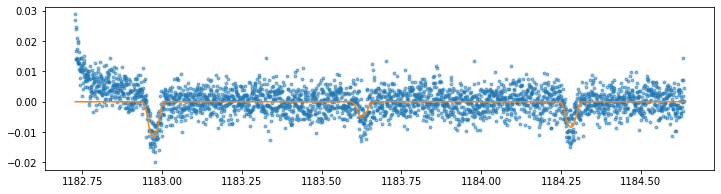

In [168]:
plt.figure(figsize=(12,3))
plt.plot(t[:2800],flux[:2800],'.',alpha=0.5)
plt.plot(t[:2800],map_estimate["model_lc"][:2800])

In [169]:
map_estimate

{'b_interval__': array(1.81056199),
 't_offset_interval__': array(-0.0058004),
 'log_depths_interval__': array([ 0.02999827, -0.46982013, -0.16005066, -0.94477328, -0.24607418,
        -0.928807  ,  0.01636781, -0.98685757, -0.14863451, -2.05129333,
        -1.02858739, -1.71758513, -0.16172674, -1.02291174, -0.20780814,
        -0.08220675]),
 'dust_vel_interval__': array(0.03036088),
 'log_rad_growth_interval__': array(53.85137972),
 'log_dust_dispersion_interval__': array(-63.24709864),
 'u_star_tess_interval__': array([28.98271714, -1.77635541]),
 'b': array(0.81645829),
 't_offset': array(-0.00075817),
 'log_depths': array([-4.44750696, -5.30738828, -4.77949228, -6.04043979, -4.92846992,
        -6.01783232, -4.47135697, -6.09926751, -4.75963258, -7.20254766,
        -6.15649358, -6.93472267, -4.78240653, -6.14877568, -4.86236116,
        -4.64378084]),
 'dust_vel': array(0.00455378),
 'sma_phantom': array(0.01345041),
 'per_phantom': array(0.65357413),
 'ecc_phantom': array(0.004

In [170]:
with model:
    #step = pm.Metropolis()
    #trace = pm.sample(500, step)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /Users/hosborn/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u_star_tess, log_dust_dispersion, log_rad_growth, dust_vel, log_depths, t_offset, b]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [1:11:55<00:00,  1.08s/draws]
INFO (theano.gof.compilelock): Refreshing lock /Users/hosborn/.theano/compiledir_Darwin-19.6.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
/Users/hosborn/t

In [171]:
pm.summary(trace,var_names=['b', 't_offset', 'dust_vel', 'sma_phantom', 'per_phantom',
                            'ecc_phantom', 'log_rad_growth', 'log_dust_dispersion', 'u_star_tess'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.902,0.012,0.880,0.924,0.001,0.001,104.0,104.0,107.0,182.0,1.04
t_offset,0.007,0.002,0.005,0.010,0.000,0.000,32.0,32.0,43.0,55.0,1.07
dust_vel,-0.054,0.100,-0.169,0.139,0.048,0.036,4.0,4.0,7.0,37.0,1.63
sma_phantom,0.014,0.000,0.013,0.014,0.000,0.000,57.0,57.0,48.0,210.0,1.08
per_phantom,0.667,0.007,0.655,0.679,0.001,0.001,58.0,58.0,48.0,210.0,1.08
ecc_phantom,0.110,0.031,0.043,0.162,0.005,0.003,43.0,43.0,48.0,210.0,1.08
log_rad_growth,-2.514,5.120,-9.994,6.736,1.310,0.945,15.0,15.0,18.0,231.0,1.19
log_dust_dispersion,5.477,2.133,2.283,9.517,0.351,0.252,37.0,36.0,39.0,103.0,1.08
u_star_tess[0],0.478,0.049,0.394,0.574,0.002,0.001,587.0,587.0,569.0,733.0,1.01
u_star_tess[1],0.172,0.049,0.085,0.263,0.002,0.001,798.0,798.0,817.0,875.0,1.01


In [ ]:
pm.summary(trace,var_names=['log_depths'])

/Users/hosborn/transits/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


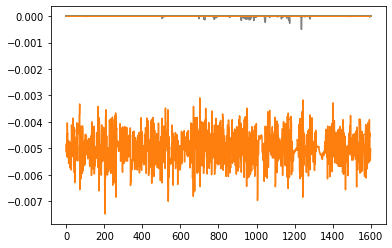

In [175]:
plt.plot(trace['model_lc'][:1600,np.random.choice(len(trace['log_rad_growth']),12)])

In [111]:
np.nanmin(trace['ecc_phantom'])

/Users/hosborn/transits/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


nan

In [164]:
np.sqrt(abs(1.0/0.6666-1))

0.7072128498560388

0.5773502691896258

In [161]:
np.sqrt(1-1.0/1.5)

0.5773502691896258

In [95]:
trace.varnames

['b_interval__',
 't_offset_interval__',
 'log_depths_interval__',
 'dust_vel_interval__',
 'log_rad_growth_interval__',
 'log_dust_dispersion_interval__',
 'u_star_tess_interval__',
 'b',
 't_offset',
 'log_depths',
 'dust_vel',
 'sma_phantom',
 'per_phantom',
 'ecc_phantom',
 'log_rad_growth',
 'planet_ratios',
 'log_dust_dispersion',
 'dispersion',
 'u_star_tess',
 'model_lc']

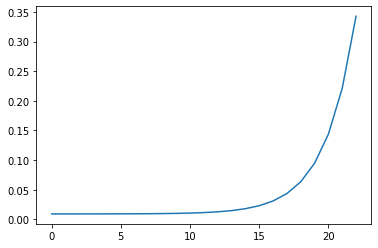

In [57]:
log_rad_growth=10.0
planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
plt.plot((planet_ratios_init-planet_ratios_init[0])/(3*planet_ratios_init[-1])+init_planet_ratio)

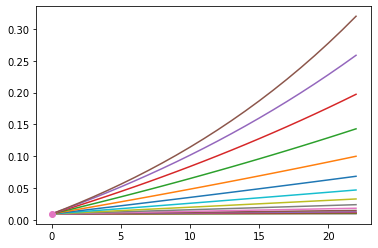

In [21]:
for log_rad_growth in np.arange(-7,1.0,0.5):
    planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(1,2,n_steps)
    plt.plot((planet_ratios_init-planet_ratios_init[0])/(2*planet_ratios_init[-1])+init_planet_ratio) #Limiting it at 0.5
plt.plot([0],[init_planet_ratio],'o')

In [ ]:
for log_rad_growth in np.arange(-6,0.0,0.5):
    init_planet_ratio = 0.01
    planet_ratios_init= init_planet_ratio+(1+np.exp(log_rad_growth))**np.linspace(2,1,n_steps)
    planet_ratios     = (planet_ratios_init-planet_ratios_init[-1])/(2*planet_ratios_init[0])+init_planet_ratio
    plt.plot(planet_ratios)


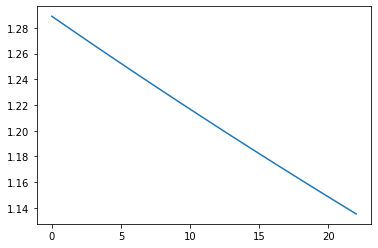

In [16]:
plt.plot((1+np.exp(-2))**np.linspace(2,1,n_steps))